### Forecast the CocaCola prices data set. 
Prepare a document for each model explaining 
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.

In [1]:
# Import libraries
from pandas import read_csv
from matplotlib import pyplot
from numpy import sqrt
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [3]:
data =pd.read_excel("CocaCola_Sales_Rawdata.xlsx")

In [4]:
data.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [5]:
data.shape

(42, 2)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [16]:
data.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


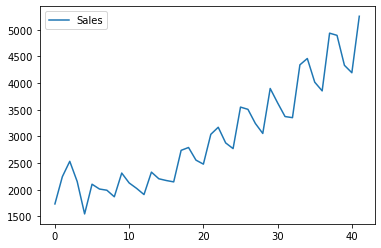

In [17]:
# line plot of time series
from pandas import read_csv
from matplotlib import pyplot
data.plot()
pyplot.show()

###  Time series decomposition plot 

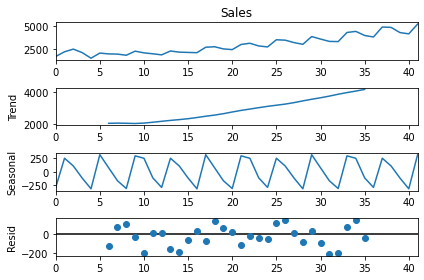

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_ts_add = seasonal_decompose(data.Sales,freq=12)
decompose_ts_add.plot()
plt.show()

   ### Data includes the upward trend and the seasonality.

array([[<AxesSubplot:title={'center':'Sales'}>]], dtype=object)

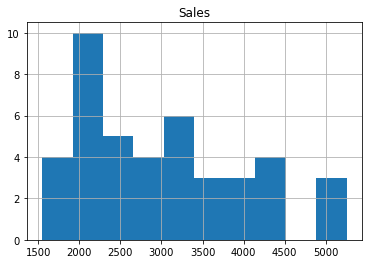

In [18]:
data.hist()

<AxesSubplot:ylabel='Density'>

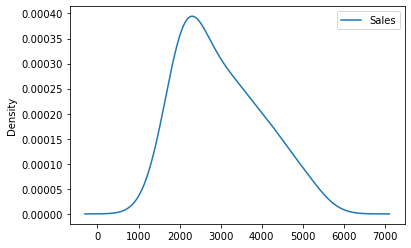

In [19]:
data.plot(kind='kde')

In [32]:
data1= data.drop('Quarter', 1)

### Data is more in the normal distribution form.

In [41]:
# separate out a validation dataset
split_point = len(data1) - 10
dataset, validation = data1[0:split_point], data1[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header=False)
validation.to_csv('validation.csv', header=False)

Dataset 32, Validation 10


In [42]:
print("{} {}".format(len(dataset), len(validation)))

32 10


In [43]:
data1.head()

,Sales
0,1734.827000
1,2244.960999
2,2533.804993
3,2154.962997
4,1547.818996


#### Persistence/ Base model



In [44]:
# evaluate a persistence model
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
train = read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [45]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=2173.968, Expected=2148.278
>Predicted=2148.278, Expected=2739.308
>Predicted=2739.308, Expected=2792.754
>Predicted=2792.754, Expected=2556.010
>Predicted=2556.010, Expected=2480.974
>Predicted=2480.974, Expected=3039.523
>Predicted=3039.523, Expected=3172.116
>Predicted=3172.116, Expected=2879.001
>Predicted=2879.001, Expected=2772.000
>Predicted=2772.000, Expected=3550.000
>Predicted=3550.000, Expected=3508.000
>Predicted=3508.000, Expected=3243.860
>Predicted=3243.860, Expected=3056.000
>Predicted=3056.000, Expected=3899.000
>Predicted=3899.000, Expected=3629.000
>Predicted=3629.000, Expected=3373.000
RMSE: 387.510


### ARIMA Hyperparameters

In [195]:
# grid search ARIMA parameters for a time series

import warnings
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt



#### Grid search for p,d,q values

In [106]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [128]:
# load dataset
train = read_csv('dataset.csv', header=None, index_col=0)
# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 4)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=961.865
ARIMA(0, 0, 1) RMSE=688.005
ARIMA(0, 0, 2) RMSE=414.867
ARIMA(0, 0, 3) RMSE=570.669
ARIMA(0, 1, 0) RMSE=427.100
ARIMA(0, 1, 1) RMSE=413.511
ARIMA(0, 1, 2) RMSE=373.992
ARIMA(0, 1, 3) RMSE=319.964
ARIMA(0, 2, 0) RMSE=660.437
ARIMA(0, 2, 1) RMSE=450.463
ARIMA(0, 2, 2) RMSE=361.779
ARIMA(0, 2, 3) RMSE=374.056
ARIMA(1, 0, 0) RMSE=488.624
ARIMA(1, 0, 1) RMSE=482.988
ARIMA(1, 1, 0) RMSE=421.282
ARIMA(1, 1, 1) RMSE=387.026
ARIMA(1, 2, 0) RMSE=638.348
ARIMA(1, 2, 1) RMSE=448.214
ARIMA(2, 0, 0) RMSE=498.144
ARIMA(2, 1, 0) RMSE=307.226
ARIMA(2, 1, 1) RMSE=312.201
ARIMA(2, 2, 0) RMSE=526.044
ARIMA(2, 2, 1) RMSE=315.213
ARIMA(3, 0, 0) RMSE=399.817
ARIMA(3, 1, 0) RMSE=221.799
ARIMA(3, 2, 0) RMSE=138.946
Best ARIMA(3, 2, 0) RMSE=138.946


 #### Build Model based on the optimized values

In [52]:
# save finalized model to file
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy

In [109]:
# load data
train = read_csv('dataset.csv', header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

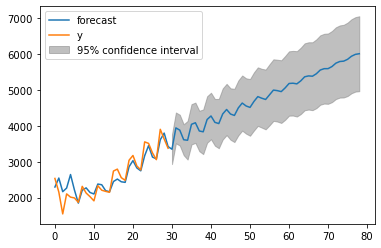

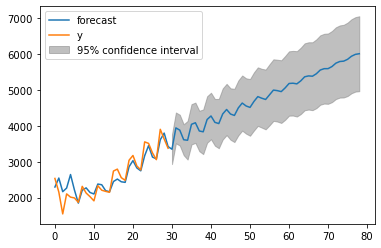

In [180]:
# fit model
model = ARIMA(X, order=(3,1,0))
model_fit = model.fit()
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1, 79)

In [112]:
#Error on the test data
val=pd.read_csv('validation.csv',header=None)
rmse = sqrt(mean_squared_error(val[1], forecast))
rmse

686.9734026675303

##  ACF plots and PACF plots

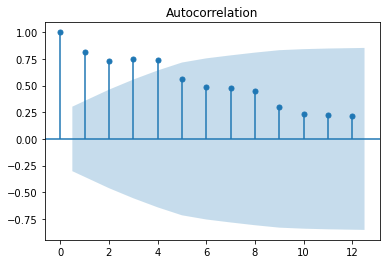

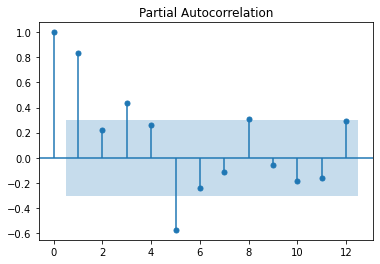

In [113]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(data.Sales,lags=12)
tsa_plots.plot_pacf(data.Sales,lags=12)
plt.show()


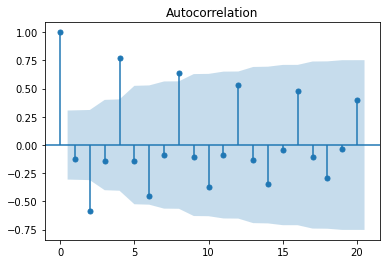

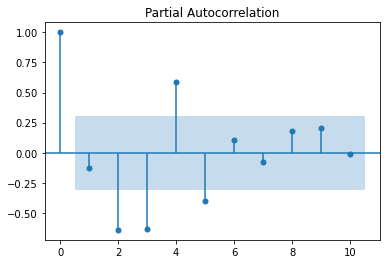

In [123]:
first_diff = data.Sales- data.Sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
tsa_plots.plot_acf(first_diff,lags=20)
tsa_plots.plot_pacf(first_diff,lags=10)
plt.show()

#### Combine train and test data and build final model

In [198]:
# fit model

train =pd.read_excel("CocaCola_Sales_Rawdata.xlsx", header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [199]:
model = ARIMA(X, order=(3,1,0))
model_fit = model.fit()

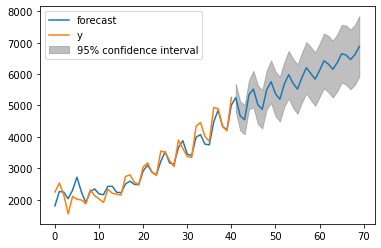

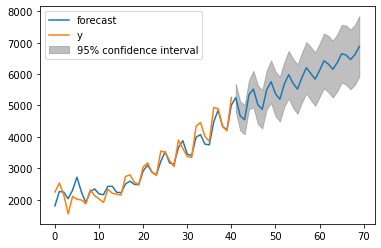

In [216]:
forecast=model_fit.forecast(steps=10)[0]
model_fit.plot_predict(1,70)

In [217]:
forecast

array([5249.54586025, 4667.82509857, 4548.21731867, 5345.01676535,
       5520.50793852, 5023.90233252, 4877.36049667, 5494.99298881,
       5757.71356476, 5371.73290523])

## Seasonal ARIMA
### As the data is seasonal, only ARIMA is not enough for predict the forcast. Therefore, here we considered the Sesonal ARIMA model.¶

In [208]:

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults,ARMA,ARMAResults
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [209]:

train =pd.read_excel("CocaCola_Sales_Rawdata.xlsx", header=0, index_col=0, parse_dates=True)
# prepare data
X = train.values
X = X.astype('float32')

In [210]:
Sarimax_model = auto_arima(X,
                       start_P=1,
                       start_q=1,
                       max_p=3,
                       max_q=3,
                       m=12,
                       seasonal=True,
                       d=None,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)
Sarimax_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=405.576, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=402.446, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=406.443, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=406.440, Time=0.05 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=404.444, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=404.444, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=404.445, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=404.443, Time=0.02 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=405.084, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=403.610, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.708 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   42
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -200.223
Date:                            Sat, 18 Dec 2021   AIC                            402.446
Time:                                    23:36:30   BIC                            403.813
Sample:                                         0   HQIC                           402.874
                                             - 42                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.813e+04   1.67e+04      3.472      0.001    2.53e+04    9.09e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.54
Prob(Q):                              0.88   Prob(JB):                         0.76
Heteroskedasticity (H):               0.54   Skew:                             0.22
Prob(H) (two-sided):                  0.35   Kurtosis:                         2.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [247]:
model_S = SARIMAX(X,order=(0,1,0),
              seasonal_order=(0, 1, 0, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results = model_S.fit()

In [248]:
forecast_S = results.predict(start = 0,
                           end=len(X)+24,
                           typ='levels')

In [249]:
forecast_S

array([   0.        , 1734.82702637, 2244.9609375 , 2533.80493164,
       2154.96289062, 1547.81896973, 2104.41210938, 2014.36303711,
       1991.74694824, 1869.05004883, 2313.63208008, 2128.32006836,
       3183.3803304 , 2420.73791504, 2620.0090332 , 1827.70800781,
       1566.82409668, 2704.87121582, 2649.2590332 , 2770.13781738,
       2433.31311035, 2925.55615234, 2854.2109375 , 3070.62487793,
       2762.77600098, 3192.56103516, 3425.38500977, 3475.41796875,
       3218.17016602, 3647.0300293 , 3952.44580078, 3392.25610352,
       3297.96411133, 3910.54882812, 4474.59301758, 4167.88500977,
       3909.99902344, 4632.        , 4894.        , 4630.86010742,
       4145.13989258, 5037.        , 4983.        , 4727.        ,
       4706.        , 5696.        , 5815.        , 5371.        ,
       5208.        , 6290.        , 6249.        , 5687.        ,
       5548.        , 6607.        , 6337.        , 6081.        ,
       6060.        , 7050.        , 7169.        , 6725.     

In [250]:
df = pd.DataFrame(forecast_S, columns = ['forecast'])

In [251]:
df

,forecast
0,0.000000
1,1734.827026
2,2244.960938
3,2533.804932
4,2154.962891
...,...
62,7603.000000
63,7041.000000
64,6902.000000
65,7961.000000


<AxesSubplot:>

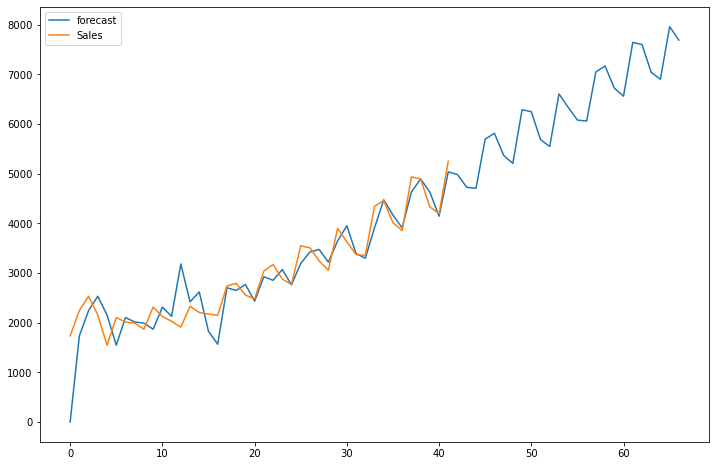

In [254]:
df.plot(legend=True)
data['Sales'].plot(figsize=(12,8),legend=True)